# Multidecadal pattern of AR(1) variability

In [1]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import sys
import xarray as xr
sys.path.append('../../lib')
from regimeshifts import ews

In [2]:
## Reading labels
rec_labels = pd.read_csv('output/sel_rec_labels.csv',index_col=0)

In [3]:
data_path = 'output/sel_records_data.csv'
md_path = 'output/sel_records_metadata.csv'
sel_rec = pd.read_csv(data_path, index_col=0)
sel_rec_md = pd.read_csv(md_path, index_col=0)
data_path = '../../../datasets/bivalve-sclerochronologies/'
nfs_ds = pd.read_csv(data_path+sel_rec_md.loc['SPNF_PP_GD']['file'],index_col=0)

In [4]:
recs_multid_pattern = ['IS_PB_NEars','TP_DR_NEars','FG_JEM_PAD','SPNF_PP_GD','Faroe_FWB_NEars',
                       'BS_MM_d18O',
                       'FG_PB_B_LCars', 'FG_PB_C_LCars','FG_PB_F5_LCars',
                       'Norw_HH_RCS','NIS_DR_d18O','NIS_PB_NEars']

In [5]:
selection = []
long_r_200 = []
long_r_100 = []
for rec_id in recs_multid_pattern:
    ts = sel_rec[rec_id]
    fi = 1900 if ts.first_valid_index() < 1900 else ts.first_valid_index()
    li = ts.last_valid_index()
    ts_sl = ts[(ts.index>=fi)&(ts.index<=li)]
    notnan_ratio = len(ts_sl.dropna())/ (ts_sl.index.max() - ts_sl.index.min())
    if fi <= 1900 and li >= 1960 and notnan_ratio > 0.95:
        selection.append(rec_id)
    if ts.first_valid_index() <= 1710 and notnan_ratio > 0.95:
        long_r_200.append(rec_id)
    if ts.first_valid_index() <= 1810 and notnan_ratio > 0.95:
        long_r_100.append(rec_id)

In [6]:
wL = 50
bW = 15
ar1 = ews.Ews(sel_rec[recs_multid_pattern]).ar1(detrend=True,bW=bW,wL=wL)
### Obtaining residuals and the standadised version of the records
ar1_last_d = ar1[ar1.index>=1850]
ar1_res = ar1_last_d - ar1_last_d.mean()
ar1_std = (ar1_last_d - ar1_last_d.mean())/ar1_last_d.mean()
ar1_norm = (ar1_last_d - ar1_last_d.mean())/(ar1_last_d.max()-ar1_last_d.min())

In [7]:
lambd = ews.Ews(sel_rec[recs_multid_pattern]).lambd(detrend=True,bW=bW,wL=wL+1)
### Obtaining residuals and the standadised version of the records
lambd_last_d = lambd[lambd.index>=1850]
lambd_res = lambd_last_d - lambd_last_d.mean()

In [8]:
### Following the definition by Swingedouw
### We define SPG as the box 70°W–20°W, 45°N–60°N
coors_spg = [[-70,-20],[45,60]]

In [9]:
### EN4 over the SPG region
en4_file = '../../../datasets/EN4/EN.4.2.2.analyses.g10/*.nc'
en4 = xr.open_mfdataset(en4_file,combine='by_coords')
en4 = en4.sel(depth=slice(*[0,100]))
en4 = en4.assign_coords(lon=(((en4.lon + 180) % 360) - 180))
en4 = en4.sortby(en4.lon)
en4_atl = en4.sel(lon =slice(*coors_spg[0]), lat = slice(*coors_spg[1])) ## 
## Averaging the first 100m
en4_avg_depth = en4_atl.temperature.mean(dim='depth').to_dataset()
en4_ann = en4_avg_depth.resample(time='A').mean().load()
en4_sg = en4_ann.mean(dim=['lat','lon']).to_dataframe()
en4_sg.index = en4_sg.index.year

/home/ra499/miniconda3/lib/python3.12/site-packages/xarray/core/groupby.py:508: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


In [11]:
hadisst_file = '../../../datasets/HADISST/HadISST_sst.nc'
hadisst = xr.open_mfdataset(hadisst_file)
hadisst = hadisst.sortby(hadisst.latitude)
hadisst = hadisst.drop('time_bnds')
hadisst = hadisst.where(hadisst.sst>=-2).sel(longitude=slice(*coors_spg[0]), latitude = slice(*coors_spg[1]),
                                            time=hadisst['time.year']<=2023)
hadisst_ann = hadisst.resample(time='A', skipna=True).mean().load()
hadisst_sg = hadisst_ann.mean(dim=['latitude','longitude']).to_dataframe()
hadisst_sg.index = hadisst_sg.index.year

/home/ra499/miniconda3/lib/python3.12/site-packages/xarray/core/groupby.py:508: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


In [12]:
wL = 50
bW = 15
ar1_sst_sg = ews.Ews(hadisst_sg).ar1(detrend=True,wL=wL,bW=bW)
var_sst_sg = ews.Ews(hadisst_sg).var(detrend=True,wL=wL,bW=bW)
ar1_sst_sg_res = ar1_sst_sg - ar1_sst_sg.mean()
ar1_en4_sg = ews.Ews(en4_sg).ar1(detrend=True,wL=wL,bW=bW)
lambd_en4_spg = ews.Ews(en4_sg).lambd(detrend=True,wL=wL+1,bW=bW)
lambd_en4_sg_res = lambd_en4_spg - lambd_en4_spg.mean()
var_en4_sg = ews.Ews(en4_sg).var(detrend=True,wL=wL,bW=bW)
ar1_en4_sg_res = ar1_en4_sg - ar1_en4_sg.mean()

/tmp/ipykernel_11742/1753567454.py:6: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(1850, 1920, facecolor="none",color='tab:orange', alpha=0.1,lw=0, zorder = 10)
/tmp/ipykernel_11742/1753567454.py:7: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(1955, 2015, facecolor="none",color='tab:orange', alpha=0.1,lw=0, zorder = 10)


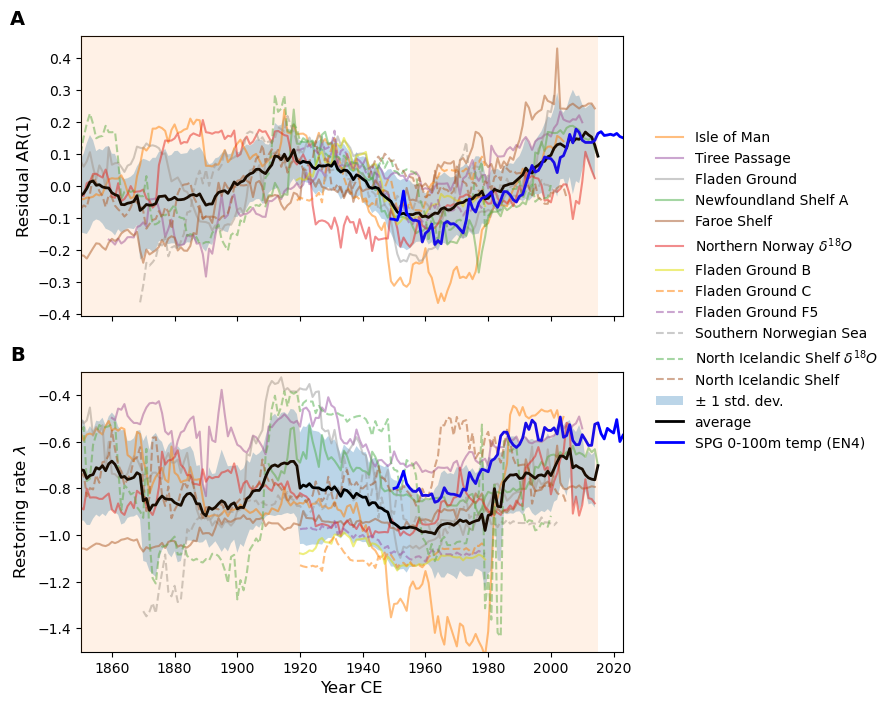

In [13]:
color_cycle = ['#ff7f00', '#984ea3','#999999','#4daf4a',
               '#a65628', '#e41a1c', '#dede00']
styl_list=['-','--','-.',':'] # list of basic linestyles
fig, axs = plt.subplots(2,1,figsize=(7,8),facecolor='white',sharex=True)
for ax in axs:
    ax.axvspan(1850, 1920, facecolor="none",color='tab:orange', alpha=0.1,lw=0, zorder = 10)
    ax.axvspan(1955, 2015, facecolor="none",color='tab:orange', alpha=0.1,lw=0, zorder = 10)
for i,r in enumerate(recs_multid_pattern):
    clr=color_cycle[i % len(color_cycle)]
    styl=styl_list[i // len(color_cycle)]
    ar1_res[r].plot(ax=axs[0],linestyle=styl,alpha=0.5,color=clr,label=rec_labels.loc[r,'label'])   
    lambd[r].plot(ax=axs[1],linestyle=styl,alpha=0.5,color=clr,label=rec_labels.loc[r,'label'])
 
std = ar1_res[recs_multid_pattern].std(axis=1)
avg = ar1_res[recs_multid_pattern].mean(axis=1)
axs[0].fill_between(ar1_res.index,avg+std,avg-std,
                 alpha=0.3,label='± 1 std. dev.')
avg.plot(ax=axs[0],color='k',linewidth=2,label='average')

stdl = lambd[recs_multid_pattern].std(axis=1)
avgl = lambd[recs_multid_pattern].mean(axis=1)
axs[1].fill_between(lambd.index,avgl+stdl,avgl-stdl,
                 alpha=0.3,label='± 1 std. dev.')
avgl.plot(ax=axs[1],color='k',linewidth=2,label='average')

#ar1_sst_sg_res['sst'].plot(ax=axs,color='red',linewidth=2,linestyle='--',label='SPG SST (HadISST)')
ar1_en4_sg_res['temperature'].plot(ax=axs[0],color='blue',linewidth=2,label='SPG 0-100m temp (EN4)')
lambd_en4_spg['temperature'].plot(ax=axs[1],color='blue',linewidth=2,label='SPG 0-100m temp (EN4)')

axs[1].set_xlabel('Year CE',fontsize=12)
axs[0].set_ylabel('Residual AR(1)',fontsize=12);
axs[1].set_ylabel(r'Restoring rate $\lambda$',fontsize=12);
axs[1].set_xlim(1850,2023);
axs[1].set_ylim(-1.5,-0.3);
axs[0].legend(frameon=False,loc=(1.05,-0.5));
axs[0].text(x=-0.13,y=1.04,s='A',transform=axs[0].transAxes,fontsize=14,fontweight='bold')
axs[1].text(x=-0.13,y=1.04,s='B',transform=axs[1].transAxes,fontsize=14,fontweight='bold');
fig.savefig(f'img/AR1_lambda_ts_1850_sel_rec_bW{bW}.png', dpi=350, bbox_inches='tight')

/tmp/ipykernel_11742/1493829733.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(1850, 1920, facecolor="none",color='tab:orange', alpha=0.1,lw=0, zorder = 10)
/tmp/ipykernel_11742/1493829733.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(1955, 2005, facecolor="none",color='tab:orange', alpha=0.1,lw=0, zorder = 10)


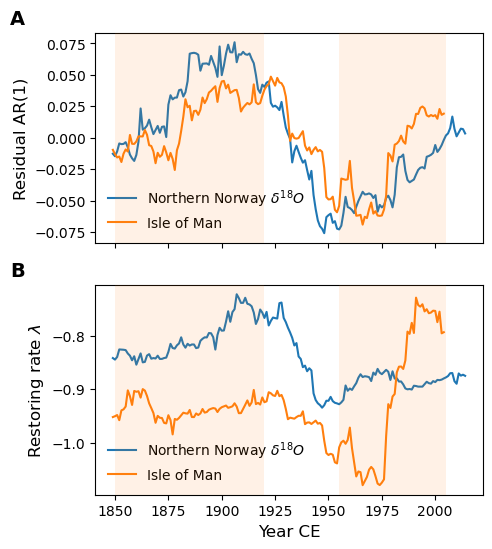

In [14]:
### Selecting long-enough records showing a significant increasing trend before 1920
wL = 200
bW = 14
long_rec = ['BS_MM_d18O','IS_PB_NEars']
long_r = ews.Ews(sel_rec[long_rec][sel_rec.index>=1650])
ar1_long = long_r.pearsonc(detrend=True,bW=bW,wL=wL)
lamb_long = long_r.lambd(detrend=True,bW=bW,wL=wL)
ar1_long_res = ar1_long - ar1_long.mean()
lamb_long_res = lamb_long - lamb_long.mean()

fig, axs = plt.subplots(2,1,figsize=(5,6),facecolor='white',sharex=True)
for r in long_r:
    ar1_long_res[r].plot(ax=axs[0],label=rec_labels.loc[r,'label']) 
    lamb_long[r].plot(ax=axs[1],label=rec_labels.loc[r,'label']) 
for ax in axs:
    ax.legend(frameon=False);
    ax.axvspan(1850, 1920, facecolor="none",color='tab:orange', alpha=0.1,lw=0, zorder = 10)
    ax.axvspan(1955, 2005, facecolor="none",color='tab:orange', alpha=0.1,lw=0, zorder = 10)
axs[1].set_xlabel('Year CE',fontsize=12)
axs[0].set_ylabel('Residual AR(1)',fontsize=12);
axs[1].set_ylabel(r'Restoring rate $\lambda$',fontsize=12);
axs[0].text(x=-0.22,y=1.04,s='A',transform=axs[0].transAxes,fontsize=14,fontweight='bold')
axs[1].text(x=-0.22,y=1.04,s='B',transform=axs[1].transAxes,fontsize=14,fontweight='bold');
fig.savefig(f'img/AR1_lambda_ts_long_rec_wL{wL}.png', dpi=300, bbox_inches='tight')